In [182]:
import requests
import os
import json
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [183]:
# Function to make API calls and store data
def get_noaa_data(api_key, year, start_date, end_date):
    base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    dataset_id = "GHCND"
    datatypeid = "TMIN,TMAX"
    location_id = "ZIP:80249"
    units = "standard"
    limit = 1000
    includemetadata = False
    
    # Set up query parameters
    params = {
        'datasetid': dataset_id,
        'datatypeid': datatypeid,
        'locationid': location_id,
        'units': units,
        'startdate': start_date,
        'enddate': end_date,
        'limit': limit,
        'includemetadata': includemetadata
    }

    # Make API call
    headers = {'token': api_key}
    response = requests.get(base_url, params=params, headers=headers)

    # Check if API call was successful
    if response.status_code == 200:
        # Parse and store data
        data = response.json()

        # Create 'data/' directory if it doesn't exist
        os.makedirs('data', exist_ok=True)
        
        file_name = f"data/winter_{year}-{year + 1}.json"
        with open(file_name, 'w') as file:
            json.dump(data, file)
        print(f"Data for {year}-{year + 1} stored successfully.")
    else:
        print(f"Failed to fetch data for {year}-{year + 1}. Error: {response.status_code}")


In [184]:
# Use your obtained API key
api_key = "SzxMcHwluZbVsVQOgGepSrQvMPnttVAu"

# Specify date ranges
date_ranges = ("12-15", "01-21")

In [185]:
# Iterate over years
for year in range(2008, 2022):
    start_date, end_date = date_ranges
    end_date = str(year+1)+"-"+end_date
    start_date = str(year)+"-"+start_date
    get_noaa_data(api_key, year, start_date, end_date)

Data for 2008-2009 stored successfully.
Data for 2009-2010 stored successfully.
Data for 2010-2011 stored successfully.
Data for 2011-2012 stored successfully.
Data for 2012-2013 stored successfully.
Data for 2013-2014 stored successfully.
Data for 2014-2015 stored successfully.
Data for 2015-2016 stored successfully.
Data for 2016-2017 stored successfully.
Data for 2017-2018 stored successfully.
Data for 2018-2019 stored successfully.
Data for 2019-2020 stored successfully.
Data for 2020-2021 stored successfully.
Data for 2021-2022 stored successfully.


In [186]:
def average(df):
    return df["TAVG"].mean()

def average_warmest(df):
    return df["TMAX"].mean()

def average_coldest(df):
    return df["TMIN"].mean()

In [187]:
def generateMinMaxAvgCSV():
    all_data = []

    for year in range(2008, 2022):
        # Read JSON data into a DataFrame
        with open(f"data/winter_{year}-{year+1}.json", 'r') as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['results'])

        # Convert 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'])

        # Split DataFrame into two separate DataFrames for TMAX and TMIN
        tmax_df = df[df['datatype'] == 'TMAX'].copy()
        tmin_df = df[df['datatype'] == 'TMIN'].copy()

        # Merge TMAX and TMIN DataFrames on 'date'
        merged_df = pd.merge(tmax_df, tmin_df, on='date', suffixes=('_TMAX', '_TMIN'))

        # Calculate TAVG and format date
        merged_df['TAVG'] = (merged_df['value_TMAX'] + merged_df['value_TMIN']) / 2
        merged_df['Date'] = merged_df['date'].dt.strftime("%Y-%m-%d")

        # Rename columns
        merged_df.rename(columns={'value_TMAX': 'TMAX', 'value_TMIN': 'TMIN'}, inplace=True)

        # Select relevant columns and set 'date' as index
        merged_df = merged_df.set_index('Date')[['TMAX', 'TMIN', 'TAVG']]

        # Append to all_data list
        all_data.append(merged_df)

    # Concatenate all DataFrames into a single DataFrame
    all_data_df = pd.concat(all_data)

    # Sort DataFrame by date
    all_data_df.sort_index(inplace=True)

    # Write DataFrame to CSV
    csv_file_path = 'data/all_data_max_min_avg.csv'
    all_data_df.to_csv(csv_file_path)

    all_data_df

    print(f'CSV file created at: {csv_file_path}')

In [188]:
# Place the aggreagte of all json into a single CSV file.
generateMinMaxAvgCSV()

CSV file created at: data/all_data_max_min_avg.csv


In [189]:
def generateYearlyAvgCSV():
    # Read the previously generated CSV file
    csv_file_path = 'data/all_data_max_min_avg.csv'
    df = pd.read_csv(csv_file_path, index_col='Date')
    
    # Create a defaultdict to organize data by year and date
    year_data = defaultdict(dict)

    # Populate the defaultdict
    for date, row in df.iterrows():
        year, month, day = date.split('-')
        key = f"{month}-{day}"
        year_data[key][year] = row['TAVG']

    # Determine the range of years based on the available data
    all_years = sorted(set(year for date_data in year_data.values() for year in date_data.keys()))

    # Create a list to store the rows of the DataFrame
    rows = []

    # Write data
    month = 12  # Loop only for December
    for day in range(15, 32):  # Loop from 15th to 31st
        date = f"{month:02d}-{day:02d}"
        row_data = {'Date': date}
        for year in all_years:
            row_data[f"{year}-{int(year)+1}"] = year_data[date].get(str(year), None)
        rows.append(row_data)

    month = 1  # Loop only for January
    for day in range(1, 22):  # Loop from 1st to 21st
        date = f"{month:02d}-{day:02d}"
        row_data = {'Date': date}
        for year in all_years:
            if(year == 2008):
                continue
            row_data[f"{int(year)-1}-{year}"] = year_data[date].get(str(year), None)
        rows.append(row_data)

    # Create the DataFrame from the list of rows
    yearly_avg_df = pd.DataFrame(rows)

    # Write the new CSV file
    output_file_path = 'data/all_data_avg.csv'
    yearly_avg_df.to_csv(output_file_path, index=False)

    print(f'CSV file created at: {output_file_path}')

In [190]:
# Generate yearly average CSV
generateYearlyAvgCSV()

CSV file created at: data/all_data_avg.csv


In [191]:
csv_file_path = 'data/all_data_min.csv'
df = pd.read_csv(csv_file_path)
df.set_index('Date', inplace=True)

In [192]:
df2 = pd.read_csv('data/all_data_max_min_avg.csv')
print("Average winter 'max' temperatures from 2008-2022 : ", average_warmest(df2))
print("Average winter 'min' temperatures from 2008-2022 : ", average_coldest(df2))
print("Average winter 'avg' temperatures from 2008-2022 : ", average(df2))

Average winter 'max' temperatures from 2008-2022 :  43.866279069767444
Average winter 'min' temperatures from 2008-2022 :  17.4437984496124
Average winter 'avg' temperatures from 2008-2022 :  30.655038759689923


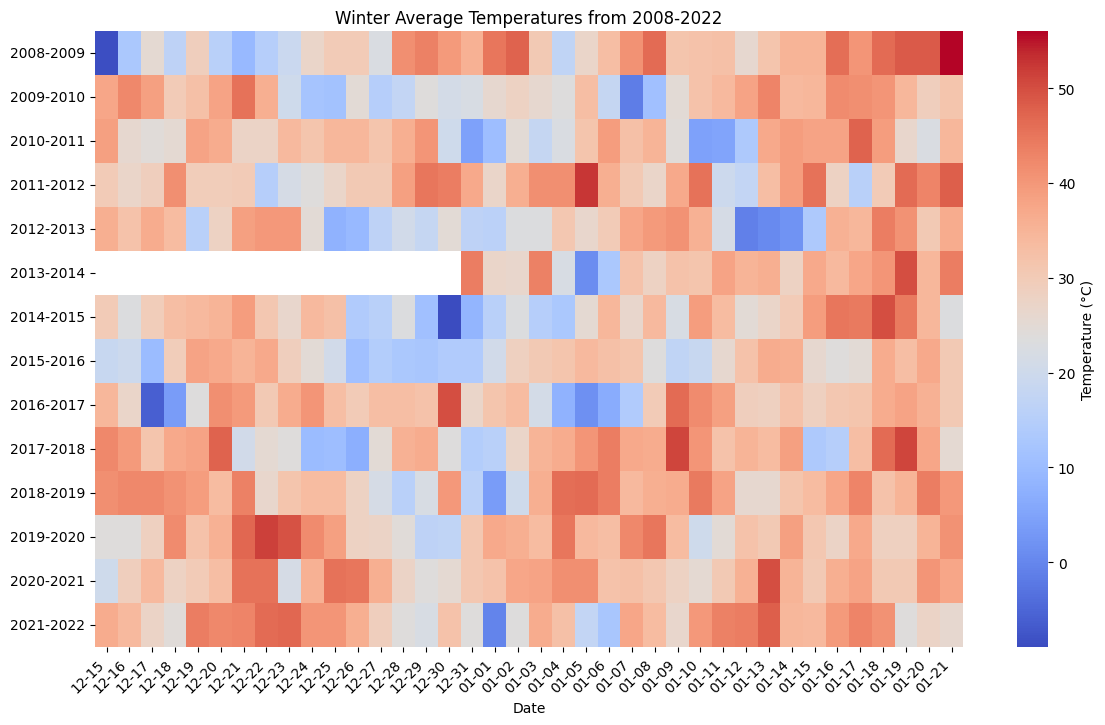

In [193]:
# Transpose the DataFrame
df = df.transpose()

# Create a heatmap using Seaborn
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(df, cmap='coolwarm', cbar_kws={'label': 'Temperature (°C)'})

# Transform x-axis ticks to display as '2008-09'
labels = [item.get_text() for item in heatmap.get_xticklabels()]
heatmap.set_xticklabels(labels, rotation=45, ha='right')  # Rotate ticks by 45 degrees

plt.title('Winter Average Temperatures from 2008-2022')
plt.show()